In [1]:
# %config IPCompleter.greedy=True
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install sklearn
# !pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import matplotlib.dates as mdates 
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline


In [3]:
def get_monthly_retrun(inputarr):
    mr = []
    for i in range(1,len(inputarr)):
        mr.append((inputarr[i]-inputarr[i-1])/inputarr[i-1])
    return np.array(mr)
    

312 312
(311, 1) (311, 1)
[0.00445727]
[[-0.00552627]]


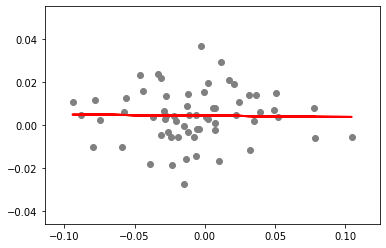

In [6]:
f_monthly = pd.read_excel('monthly.xls',sheet_name='Monthly')
f_ftse = pd.read_csv('FTSE100.csv')
house_date,house_price = f_monthly['Unnamed: 0'],f_monthly['Average House Price']
housepos = f_monthly.loc[f_monthly['Unnamed: 0'] == '2016-12-01'].index[0]
house_date,house_price = house_date[:housepos+1],house_price[:housepos+1]
ftse_date,ftse_index = f_ftse['Date'].astype('datetime64[ns]') ,f_ftse['Adj Close']
# print(house_date)


# FTSE monthly return
ftse_list = np.array(ftse_index)
house_list = np.array(house_price)
print(len(ftse_list),len(house_list))
ftse_mr,house_mr = get_monthly_retrun(ftse_list),get_monthly_retrun(house_list)

X = ftse_mr.reshape(-1,1)
Y = house_mr.reshape(-1,1)
print(X.shape,Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

y_pred = regressor.predict(X_test)
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()


In [ ]:
pos = f_monthly.loc[f_monthly['Unnamed: 0'] == '2016-12-01'].index[0]
time,price = time[:pos+1],price[:pos+1]
plt.plot_date(time,price,'-')
plt.xlabel("Year")
plt.ylabel("Average house price in pounds sterling (£)")
plt.show()